## 시퀀스를 예측하는 머신러닝 모델 만들기

#### 윈도 데이터셋 만들기

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# window 첫 매개변수에 윈도에 들어갈 개수 지정
# shift는 이전 위치에서 윈도가 이동할 거리
# drop_remainder는 데이터셋 마지막 부분에서 윈도 크기보다 적은 개수가 남았을 때 해당 윈도 버림

dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [16]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [17]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
  print(f"x = {x.numpy()}")
  print(f"y = {y.numpy()}")

x = [[5 6 7 8]
 [4 5 6 7]]
y = [[9]
 [8]]
x = [[1 2 3 4]
 [0 1 2 3]]
y = [[5]
 [4]]
x = [[3 4 5 6]
 [2 3 4 5]]
y = [[7]
 [6]]


In [18]:
# 윈도를 적용한 시계열 데이터셋 만들기
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope) 
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
        lambda window: (window[:-1], window[-1])
    )
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [20]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, 
                           shuffle_buffer_size)

In [21]:
dataset= windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
  print(feature)
  print(label)

tf.Tensor(
[[30.565239 19.610209 22.650501 30.153908 32.735462 29.768927 28.198286
  27.131008 21.099539 24.744247 25.887356 33.319077 29.590387 18.891907
  29.1584   25.439575 23.803602 30.06611  31.978613 31.292364]], shape=(1, 20), dtype=float32)
tf.Tensor([22.24876], shape=(1,), dtype=float32)


#### DNN을 만들고 시퀀스 데이터로 훈련하기

In [22]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size],
                          activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss='mse', optimizer=sgd)

In [23]:
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 5ms/step - loss: 612.3804
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 58.9563
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 48.9101
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 47.1780
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 47.1998
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 45.4729
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 45.0842
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 44.3811
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 43.9033
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 43.0473
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 42.2763
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 41.9204
Epoch 13/100
31/31 [====

#### DNN의 결과 평가하기

In [24]:
print(series[1000:1020])

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]


In [25]:
print(series[1020])

106.258606


In [26]:
print(model.predict(series[1000:1020][np.newaxis]))

1/1 [==============================] - 0s 260ms/step
[[102.50473]]


In [27]:
start_point = 1000

print(series[start_point:start_point+window_size])
print(series[start_point+window_size])
print(model.predict(
      series[start_point:start_point+window_size][np.newaxis]))

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
1/1 [==============================] - 0s 24ms/step
[[102.50473]]


#### 전반적인 예측 살펴보기

In [28]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(
      model.predict(series[time:time + window_size][np.newaxis])
  )

1/1 [==============================] - 0s 78ms/step


In [29]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [30]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

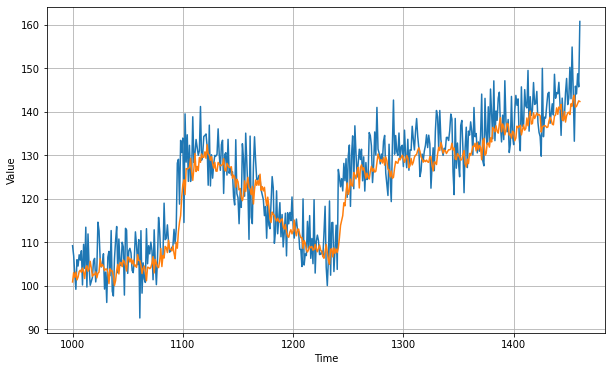

In [31]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8071465

#### 학습률 튜닝하기

In [34]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 **(epoch / 20)
)

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, 
                    callbacks=[lr_schedule], verbose=0)

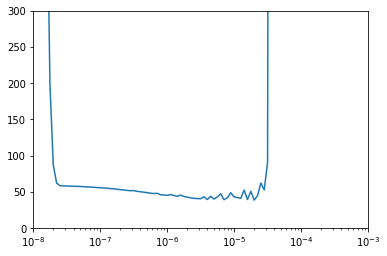

In [37]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

- 학습률을 더 낮추거나 높임으로써 손실을 줄일 수 있습니다.
- 다른 방법으로는 윈도 크기 조정, 에폭을 늘리는 법 등을 통해 손실을 줄일 수 있습니다.

#### 케라스 튜너로 하이퍼파라미터 튜닝하기

In [38]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00


In [39]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=30, step=2), 
        activation='relu', input_shape=[window_size]))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    sgd = tf.keras.optimizers.SGD(
        learning_rate=1e-6,
        momentum=hp.Choice('momentum', values=[.9, .7, .5, .3]))
    model.compile(loss="mse", optimizer=sgd)
    return model

In [40]:
from keras_tuner.tuners import RandomSearch

In [41]:
tuner = RandomSearch(build_model,
                     objective='loss', max_trials=150, 
                     executions_per_trial=3, directory='my_dir', 
                     project_name='hello', overwrite=True)

In [42]:
tuner.search(dataset, epochs=100, verbose=0)

In [43]:
tuner.results_summary()

Results summary
Results in my_dir/hello
Showing 10 best trials
Trial summary
Hyperparameters:
units: 30
momentum: 0.9
Score: 33.02508672078451
Trial summary
Hyperparameters:
units: 22
momentum: 0.9
Score: 33.235616048177086
Trial summary
Hyperparameters:
units: 28
momentum: 0.9
Score: 33.39898681640625
Trial summary
Hyperparameters:
units: 24
momentum: 0.9
Score: 33.76864242553711
Trial summary
Hyperparameters:
units: 20
momentum: 0.9
Score: 33.8277702331543
Trial summary
Hyperparameters:
units: 26
momentum: 0.9
Score: 33.86370340983073
Trial summary
Hyperparameters:
units: 16
momentum: 0.9
Score: 34.257433573404946
Trial summary
Hyperparameters:
units: 18
momentum: 0.9
Score: 34.56115595499674
Trial summary
Hyperparameters:
units: 12
momentum: 0.9
Score: 34.93472671508789
Trial summary
Hyperparameters:
units: 14
momentum: 0.9
Score: 35.148895263671875


In [44]:
best_models = tuner.get_best_models(num_models=4)

In [45]:
model = best_models[0]

forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 23ms/step


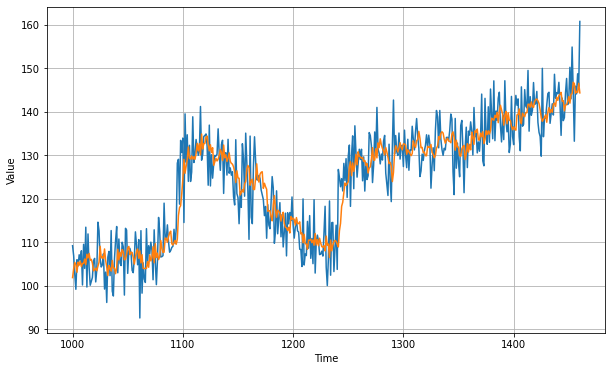

In [46]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [47]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.490068

- 케라스 튜너의 활용에 대한 추가적인 공부 필요